# Aggregating data

Data aggregation refers to a process where we combine data into groups. When
doing spatial data aggregation, we merge the geometries together into coarser
units (based on some attribute), and can also calculate summary statistics for
these combined geometries from the original, more detailed values. For example,
suppose that we are interested in studying continents, but we only have
country-level data like the country dataset. If we aggregate the data by
continent, we would convert the country-level data into a continent-level
dataset.

In this tutorial, we will aggregate our travel time data by car travel times
(column `car_r_t`), i.e. the grid cells that have the same travel time to
Railway Station will be merged together.

Let’s start with loading `intersection.gpkg`, the output file of the
[previous section](overlay-analysis):

In [3]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [4]:
import geopandas
intersection = geopandas.read_file(DATA_DIRECTORY / "intersection.gpkg")

For doing the aggregation we will use a method called `dissolve()` that takes
as input the column that will be used for conducting the aggregation:

In [5]:
# Conduct the aggregation
dissolved = intersection.dissolve(by="car_r_t")

# What did we get
dissolved.head()

,geometry,car_m_d,car_m_t,car_r_d,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE
car_r_t,,,,,,,,,,,,,,,,,,
-1,"MULTIPOLYGON (((384750 6670000, 384500 6670000...",-1,-1,-1,5913094,-1,-1,-1,-1,-1,-1,-1,-1,-1,27517366,Helsinki,Helsingfors,091
0,"POLYGON ((385750 6672000, 385750 6672250, 3860...",0,0,0,5975375,0,0,0,0,0,0,5975375,0,0,27517366,Helsinki,Helsingfors,091
7,"POLYGON ((386250 6671750, 386000 6671750, 3857...",1051,7,1051,5973739,617,5,6,617,5,6,5975375,448,6,27517366,Helsinki,Helsingfors,091
8,"MULTIPOLYGON (((386000 6671500, 385750 6671500...",1286,8,1286,5973736,706,10,10,706,10,10,5975375,706,10,27517366,Helsinki,Helsingfors,091
9,"MULTIPOLYGON (((385000 6671250, 385000 6671500...",1871,9,1871,5970457,1384,11,13,1394,11,12,5975375,1249,18,27517366,Helsinki,Helsingfors,091


Let’s compare the number of cells in the layers before and after the
aggregation:

In [6]:
print(f"Rows in original intersection GeoDataFrame: {len(intersection)}")
print(f"Rows in dissolved layer: {len(dissolved)}")

Rows in original intersection GeoDataFrame: 3826
Rows in dissolved layer: 51


Indeed the number of rows in our data has decreased and the Polygons were
merged together.

What actually happened here? Let's take a closer look. 

Let's see what columns we have now in our GeoDataFrame:

In [7]:
dissolved.columns

Index(['geometry', 'car_m_d', 'car_m_t', 'car_r_d', 'from_id', 'pt_m_d',
       'pt_m_t', 'pt_m_tt', 'pt_r_d', 'pt_r_t', 'pt_r_tt', 'to_id', 'walk_d',
       'walk_t', 'GML_ID', 'NAMEFIN', 'NAMESWE', 'NATCODE'],
      dtype='object')

As we can see, the column that we used for conducting the aggregation
(`car_r_t`) can not be found from the columns list anymore. What happened to
it?

Let’s take a look at the indices of our GeoDataFrame:

In [8]:
dissolved.index

Index([-1,  0,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56],
      dtype='int64', name='car_r_t')

Aha! Well now we understand where our column went. It is now used as index in
our `dissolved` GeoDataFrame. 

Now, we can for example select only such geometries from the layer that are for
example exactly 15 minutes away from the Helsinki Railway Station:

In [9]:
dissolved.loc[15]

geometry    MULTIPOLYGON (((384000.00013620744 6670750.000...
car_m_d                                                  7458
car_m_t                                                    13
car_r_d                                                  7458
from_id                                               5934913
pt_m_d                                                   6858
pt_m_t                                                     26
pt_m_tt                                                    30
pt_r_d                                                   6858
pt_r_t                                                     27
pt_r_tt                                                    32
to_id                                                 5975375
walk_d                                                   6757
walk_t                                                     97
GML_ID                                               27517366
NAMEFIN                                              Helsinki
NAMESWE 

In [10]:
type(dissolved.loc[15])

pandas.core.series.Series

As we can see, as a result, we have now a Pandas `Series` object containing
basically one row from our original aggregated GeoDataFrame.

Let’s also visualize those 15 minute grid cells.

First, we need to convert the selected row back to a GeoDataFrame:

In [11]:
selection = geopandas.GeoDataFrame([dissolved.loc[15]], crs=dissolved.crs)

Plot the selection on top of the entire grid:

<Axes: >

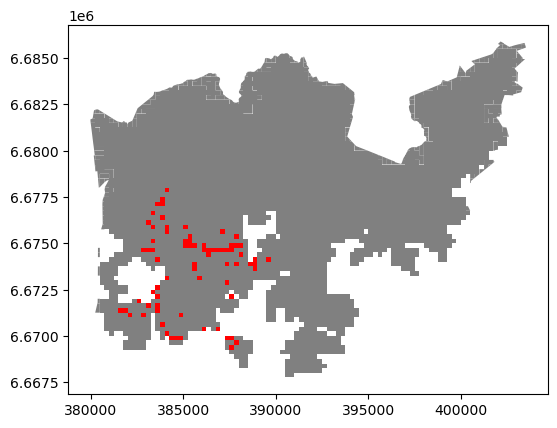

In [ ]:
# Plot all the grid cells, and the grid cells that are 15 minutes
# away from the Railway Station
ax = dissolved.plot(facecolor="gray")
selection.plot(ax=ax, facecolor="red")

Another way to visualize the travel times in the entire GeoDataFrame is to plot using one specific column. In order to use our `car_r_t` column, which is now the index of the GeoDataFrame, we need to reset the index:

In [13]:
dissolved = dissolved.reset_index()
dissolved.head()

,car_r_t,geometry,car_m_d,car_m_t,car_r_d,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE
0,-1,"MULTIPOLYGON (((384750 6670000, 384500 6670000...",-1,-1,-1,5913094,-1,-1,-1,-1,-1,-1,-1,-1,-1,27517366,Helsinki,Helsingfors,091
1,0,"POLYGON ((385750 6672000, 385750 6672250, 3860...",0,0,0,5975375,0,0,0,0,0,0,5975375,0,0,27517366,Helsinki,Helsingfors,091
2,7,"POLYGON ((386250 6671750, 386000 6671750, 3857...",1051,7,1051,5973739,617,5,6,617,5,6,5975375,448,6,27517366,Helsinki,Helsingfors,091
3,8,"MULTIPOLYGON (((386000 6671500, 385750 6671500...",1286,8,1286,5973736,706,10,10,706,10,10,5975375,706,10,27517366,Helsinki,Helsingfors,091
4,9,"MULTIPOLYGON (((385000 6671250, 385000 6671500...",1871,9,1871,5970457,1384,11,13,1394,11,12,5975375,1249,18,27517366,Helsinki,Helsingfors,091


As we can see, we now have our `car_r_t` as a column again, and can then plot the GeoDataFrame passing this column using the `column` parameter:

<Axes: >

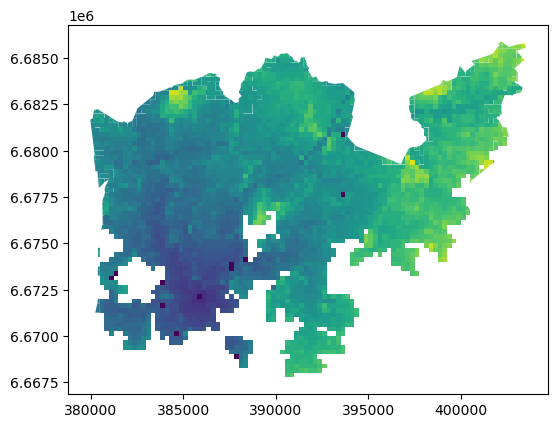

In [14]:
dissolved.plot(column="car_r_t")

> **How Are Other Columns Aggregated During `dissolve`?**  
> 
> When using the `dissolve` method in GeoPandas (e.g., `dissolved = intersection.dissolve(by="car_r_t")`), here's how other columns are aggregated:
> 
> ### Default Behavior:
> - **Default Aggregation Function:** `aggfunc='first'`
>   - Keeps the **first value** from each group for columns that are not involved in the aggregation (i.e., not the `by` column).
>   - For multiple rows grouped together, only the first row's values are retained for other columns.
> 
> ### Custom Aggregation:
> You can control how other columns are aggregated using the `aggfunc` parameter:
> ```python
> dissolved = intersection.dissolve(by="car_r_t", aggfunc="sum")
> ```
> Supported aggregation functions include:
> - `"sum"`: Sum of the values in the group.
> - `"mean"`: Average of the values in the group.
> - `"min"`: Minimum value in the group.
> - `"max"`: Maximum value in the group.
> - `"first"`: First value in the group (default).
> - `"last"`: Last value in the group.
> - Custom aggregation using a `lambda` function.
> 
> ### Using Multiple Aggregations:
> To apply different aggregations to different columns, you can do further aggregation manually:
> ```python
> dissolved = intersection.dissolve(by="car_r_t")
> dissolved = dissolved.groupby("car_r_t").agg({
>     "column1": "sum",
>     "column2": "mean",
>     "column3": "max"
> })
> ```
> 
> ### Geometry Aggregation:
> - The geometries in the grouped rows are **merged (unioned)** into a single geometry for each group.